In [75]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.style.use([
    'grid',
    'notebook'
])

In [76]:
k1, k2, k3 = 1.04*(16.46), 0.95*(32.4), 0.93*(185.48)
b2, b3 = 0.95*(-83.93), 0.93*(-167.01)

Ts = 4

sim_time = 20000
iterations = int(sim_time / Ts)

time = np.arange(0, sim_time, Ts)

r = 31
mu = 40
sigma = 55
a4 = 3019

In [77]:
def M1(Z1):
    return 20.3969566782737*Z1 - 0.0968627666122476


def N1(Z2):
    return 1.21153800621479*Z2 - 0.2389443466253


def P1(Z3):
    return 9295044.23012624*Z3 - 5970.02819190981


def M2(Z1):
    return 1 - M1(Z1)


def N2(Z2):
    return 1 - N1(Z2)


def P2(Z3):
    return 1 - P1(Z3)


pertinence_functions = np.array([
    [M1, M2],
    [N1, N2],
    [P1, P2]
])

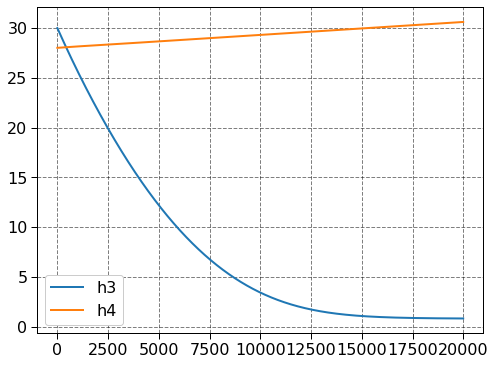

In [78]:
h3_t = np.zeros(iterations)
h4_t = np.zeros(iterations)

h3_0 = 30.
h4_0 = 28.

h3_t[0] = h3_0
h4_t[0] = h4_0

h3 = h3_0
h4 = h4_0

n = 8

A_matrices = [np.load(f'./vertices/A_{i}.npy') for i in range(n)]
B = np.load('./vertices/B.npy')

sys = np.array([
    [h3],
    [h4]]
)

u = .1

for i in range(iterations):
    diff = h4 - h3

    R43 = (k2*diff + b2)

    if h3 < 0:
        h3 = 0
    
    if h4 < 0:
        h4 = 0

    if diff < 5:
        R43 = 78

    q_43 = (diff / R43)
    q_out = .965*(k3 * np.sqrt(h3) + b3)

    a3_1 = np.cos(2.5*np.pi * (h3 - mu)) / (sigma * np.sqrt(2 * np.pi))
    a3_2 = np.exp(-(((h3 - mu)**2)) / (2 * sigma**2))

    a3 = ((3*r)/5) * (2.7*r - a3_1 * a3_2)

    Z1 = Ts/R43
    Z2 = (Ts*q_out)/a4
    Z3 = 1/a3

    v = np.array([
        [pertinence_functions[0, 0](Z1), pertinence_functions[0, 1](Z1)],
        [pertinence_functions[1, 0](Z2), pertinence_functions[1, 1](Z2)],
        [pertinence_functions[2, 0](Z3), pertinence_functions[2, 1](Z3)],
    ])

    weights = np.array([
        v[0, 1] * v[1, 1] * v[2, 1],
        v[0, 1] * v[1, 1] * v[2, 0],
        v[0, 1] * v[1, 0] * v[2, 1],
        v[0, 1] * v[1, 0] * v[2, 0],
        v[0, 0] * v[1, 1] * v[2, 1],
        v[0, 0] * v[1, 1] * v[2, 0],
        v[0, 0] * v[1, 0] * v[2, 1],
        v[0, 0] * v[1, 0] * v[2, 0],
    ])

    Ai = sum([A_matrices[j] * weights[j] for j in range(n)])
    delta_sys = (Ai @ sys) + B*u

    sys = delta_sys

    h3 = sys[0, 0]
    h4 = sys[1, 0]

    h3_t[i] = h3
    h4_t[i] = h4

plt.plot(time, h3_t, label='h3')
plt.plot(time, h4_t, label='h4')
plt.legend()